# Proyecto Grupo 5 - Análisis Musical en Spotify

# Librerias y Config

In [1]:
import datetime
import typing

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# spotify.sqlite

`spotify.sqlite` es el archivo con el que partimos este proyecto, obtenido de [los siguientes datos de kaggle](https://www.kaggle.com/datasets/maltegrosse/8-m-spotify-tracks-genre-audio-features). Contiene millones de canciones junto al analisis de caracteristicas que provee la api de spotify.

### Cargando datos

Estos se encuentran contenidos en una BDD `spotify.sqlite`, la cual tendremos en una carpeta `data`.

In [3]:
import sqlite3

# funcion para cargar las tablas de la base de datos en un diccionario de dataframes
def load_data():
  # conexion a la base de datos
  conn = sqlite3.connect(
    database='data/spotify.sqlite'
  )
  # para que no haya problemas con los caracteres especiales
  conn.text_factory = lambda b: b.decode(encoding = 'utf-8', errors = 'ignore')
  
  # lista de tablas de la base de datos
  tables = [
    "r_albums_artists",
    "r_albums_tracks",
    "r_artist_genre",
    "r_track_artist",
    "genres",
    "albums",
    "artists",
    "audio_features",
    "tracks",
  ]

  # diccionario de dataframes
  dataframes : typing.Dict[str, pd.DataFrame] = {}
  
  # cargar cada tabla en un dataframe
  for table in tables:
    dataframes[table] = pd.read_sql_query(
      sql = f"SELECT * FROM {table}",
      con = conn
    )
  
  # cerrar la conexion a la base de datos
  conn.close()

  return dataframes

# ejecutar la funcion
dataframes : typing.Dict[str, pd.DataFrame] = load_data()
[
  tracks, artists, albums, genres, audio_features, 
  r_albums_artists, r_albums_tracks, r_artist_genre, r_track_artist
] = [
  dataframes['tracks'], dataframes['artists'], dataframes['albums'], dataframes['genres'], dataframes['audio_features'] ,
  dataframes['r_albums_artists'], dataframes['r_albums_tracks'], dataframes['r_artist_genre'], dataframes['r_track_artist']
]
# ver las tablas cargadas
dataframes.keys()

dict_keys(['r_albums_artists', 'r_albums_tracks', 'r_artist_genre', 'r_track_artist', 'genres', 'albums', 'artists', 'audio_features', 'tracks'])

### Formato de las tablas

In [4]:
info_df = pd.DataFrame()
info_df['tabla'] = dataframes.keys()
info_df['filas'] = [dataframes[i].shape[0] for i in dataframes.keys()]
info_df['columnas'] = [dataframes[i].shape[1] for i in dataframes.keys()]
info_df['nombre_columnas'] = [list(dataframes[i].columns) for i in dataframes.keys()]

info_df.set_index('tabla', inplace=True)
info_df

,filas,columnas,nombre_columnas
tabla,,,
r_albums_artists,921486,2,"[album_id, artist_id]"
r_albums_tracks,9900173,2,"[album_id, track_id]"
r_artist_genre,487386,2,"[genre_id, artist_id]"
r_track_artist,11840402,2,"[track_id, artist_id]"
genres,5489,1,[id]
albums,4820754,6,"[id, name, album_group, album_type, release_date, popularity]"
artists,1066031,4,"[name, id, popularity, followers]"
audio_features,8740043,15,"[id, acousticness, analysis_url, danceability, duration, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence]"
tracks,8741672,10,"[id, disc_number, duration, explicit, audio_feature_id, name, preview_url, track_number, popularity, is_playable]"


### Estadisticas y exploración inicial

Las tablas `r_albums_artists`, `r_albums_tracks`, `r_artist_genre` y `genres` solamente contienen ids, por lo que no contienen estadisticas interesantes

#### albums

In [5]:
albums.head()

,id,name,album_group,album_type,release_date,popularity
0,2jKoVlU7VAmExKJ1Jh3w9P,"Alkaholik (feat. Erik Sermon, J Ro & Tash)",,album,954633600000,0
1,4JYUDRtPZuVNi7FAnbHyux,"Flava in Ya Ear Remix (feat. Notorious B.I.G., L.L. Cool J, Busta Rhymes, Rampage)",,single,757382400000,0
2,6YjKAkDYmlasMqYw73iB0w,Bitch Please II,,album,959040000000,0
3,2YlvHjDb4Tyxl4A1IcDhAe,Just Dippin',,compilation,1104537600000,0
4,3UOuBNEin5peSRqdzvlnWM,Still D.R.E.,,album,942710400000,0


In [6]:
albums.shape

(4820754, 6)

In [7]:
albums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4820754 entries, 0 to 4820753
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   id            object
 1   name          object
 2   album_group   object
 3   album_type    object
 4   release_date  int64 
 5   popularity    int64 
dtypes: int64(2), object(4)
memory usage: 220.7+ MB


In [8]:
albums['album_type'] = albums['album_type'].astype('category')

In [9]:
albums.describe()

,release_date,popularity
count,4820754.0000,4820754.0000
mean,1222681215510.4368,2.1524
std,469358868052.1105,8.0736
min,-62135769600000.0000,0.0000
25%,1139961600000.0000,0.0000
50%,1311033600000.0000,0.0000
75%,1414713600000.0000,0.0000
max,1644537600000.0000,100.0000


En base a las celdas anteriores, consideramos: 

- Formalizar `release_date`, estan en formato timestamp unix, por lo que seria conveniente tener esa informacion como fecha. \
  Ademas debemos tener cuidado con los timestamps negativos, los que nos pueden traer problemas (algunos van al año 0)
- Analizar si la popularidad del album es importante, pues 75% de sus valores es 0 en un rango de 0 a 100


In [10]:
albums['album_type'].value_counts()

album_type
album          3612835
compilation     766770
single          441149
Name: count, dtype: int64

In [11]:
albums['album_group'].value_counts()

album_group
    4820754
Name: count, dtype: int64

In [12]:
(albums['album_group'] == '').value_counts()

album_group
True    4820754
Name: count, dtype: int64

En base a las celdas anteriores, consideramos: 

- `album_group`, que solo contiene strings vacios, es candidato a eliminar.

#### artists

In [13]:
artists.head()

,name,id,popularity,followers
0,Xzibit,4tujQJicOnuZRLiBFdp3Ou,69,1193665
1,Erick Sermon,2VX0o9LDIVmKIgpnwdJpOJ,54,142007
2,J. Ro,3iBOsmwGzRKyR0vs2I61xP,45,158
3,Tash,22qf8cJRzBjIWb2Jc4JeOr,48,3421
4,Craig Mack,4akj4uteQQrrGxhX9Rjuyf,55,161966


In [14]:
artists.shape

(1066031, 4)

In [15]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066031 entries, 0 to 1066030
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   name        1066031 non-null  object
 1   id          1066031 non-null  object
 2   popularity  1066031 non-null  int64 
 3   followers   1066031 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 32.5+ MB


In [16]:
artists.describe()

,popularity,followers
count,1066031.0000,1066031.0000
mean,5.4179,7012.3596
std,11.9438,208718.4287
min,0.0000,0.0000
25%,0.0000,0.0000
50%,0.0000,0.0000
75%,3.0000,101.0000
max,98.0000,78503098.0000


Aqui no consideramos modificar los datos. Pero hay que considerar un analisis mas en profundidad de las columnas de popularidad y seguidores.

#### tracks

In [17]:
tracks.head()

,id,disc_number,duration,explicit,audio_feature_id,name,preview_url,track_number,popularity,is_playable
0,1dizvxctg9dHEyaYTFufVi,1,275893,1,1dizvxctg9dHEyaYTFufVi,Gz And Hustlas (feat. Nancy Fletcher),,12,0,NaN
1,2g8HN35AnVGIk7B8yMucww,1,252746,1,2g8HN35AnVGIk7B8yMucww,Big Poppa - 2005 Remaster,https://p.scdn.co/mp3-preview/770e023eb0318270ecc5caa018d758e5e0844de9?cid=cde021ca5d3e42a8bd440f1004a562dc,13,77,NaN
2,49pnyECzcMGCKAqxfTB4JZ,3,315080,0,49pnyECzcMGCKAqxfTB4JZ,"You Were Born - Early Version Of ""One Of The Three"" / Outtake",,6,8,1.0000
3,4E5IFAXCob6QqZaJMTw5YN,1,240800,1,4E5IFAXCob6QqZaJMTw5YN,Poppin' Them Thangs,https://p.scdn.co/mp3-preview/f3b556ced9657f8987d2c981014205244daf4540?cid=cde021ca5d3e42a8bd440f1004a562dc,2,70,NaN
4,1gSt2UlC7mtRtJIc5zqKWn,2,203666,0,1gSt2UlC7mtRtJIc5zqKWn,"It's Hard To Say ""I Do"", When I Don't",,2,50,NaN


In [18]:
tracks.shape

(8741672, 10)

In [19]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8741672 entries, 0 to 8741671
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                object 
 1   disc_number       int64  
 2   duration          int64  
 3   explicit          int64  
 4   audio_feature_id  object 
 5   name              object 
 6   preview_url       object 
 7   track_number      int64  
 8   popularity        int64  
 9   is_playable       float64
dtypes: float64(1), int64(5), object(4)
memory usage: 666.9+ MB


In [20]:
tracks.describe()

,disc_number,duration,explicit,track_number,popularity,is_playable
count,8741672.0000,8741672.0000,8741672.0000,8741672.0000,8741672.0000,413800.0000
mean,1.1375,236968.7389,0.0668,10.9318,6.1183,0.8754
std,0.9959,159688.6600,0.2497,22.7224,10.5798,0.3303
min,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000
25%,1.0000,169200.0000,0.0000,4.0000,0.0000,1.0000
50%,1.0000,216160.0000,0.0000,7.0000,1.0000,1.0000
75%,1.0000,273887.0000,0.0000,12.0000,8.0000,1.0000
max,63.0000,19672058.0000,1.0000,1522.0000,100.0000,1.0000


A partir de las celdas anteriores, consideramos:

- `disc_number` es candidato a eliminar, pues tiene poca varianza y algunos outliers.
- Analizar si `track_number` puede ser una columna util o no. Parece tener outliers (ver `max`).
- `is_playable` es candidato a eliminar, pues su count indica que muchos de sus valores son nulos.

In [21]:
tracks['disc_number'].value_counts()

disc_number
1     8204349
2      348328
3       80298
4       38099
5       20324
       ...   
63          6
57          5
59          5
62          4
58          3
Name: count, Length: 63, dtype: int64

In [22]:
tracks['disc_number'].max()

63

In [23]:
tracks['disc_number'].var()

0.9917664238559349

In [24]:
tracks['track_number'].value_counts()

track_number
1       806135
2       680726
3       652969
4       632889
5       603712
         ...  
1132         1
1129         1
1114         1
1121         1
999          1
Name: count, Length: 1522, dtype: int64

OPAAA, que paso ahi?
investiguemos 😎

In [25]:
tracks['track_number'].max()

1522

In [26]:
tracks[tracks['track_number'] >= 1000].sample(5)

,id,disc_number,duration,explicit,audio_feature_id,name,preview_url,track_number,popularity,is_playable
4549199,3eGBa01IS6dlE1WZEUgsDI,1,123900,0,3eGBa01IS6dlE1WZEUgsDI,Chapter 1430 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/a3c7c596da7991ed898ec838ae74c7a571645211?cid=cd552680dec84110b29ddf95d645cbe8,1430,0,NaN
3148656,6AMedKGa6AVfp4daNYTLxu,1,121500,0,6AMedKGa6AVfp4daNYTLxu,Chapter 1064 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/384ac48d1a855b1e495f272f08108b43d4d33006?cid=cd552680dec84110b29ddf95d645cbe8,1064,0,NaN
3148926,6x1JSqb7G7Xxkpt7ufgrlU,1,122400,0,6x1JSqb7G7Xxkpt7ufgrlU,Chapter 1325 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/45df5824cb5755a63ca0340e2afbcbdf6e6317aa?cid=cd552680dec84110b29ddf95d645cbe8,1325,0,NaN
3508277,2zsbl6EhOWiGs1XPkgZkTB,1,125900,0,2zsbl6EhOWiGs1XPkgZkTB,Chapter 1032 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/534ab07e764e7cb8a1d53f51e9f6f3994660076d?cid=cd552680dec84110b29ddf95d645cbe8,1032,0,NaN
3148675,0nQBzdguZhK3HSXO4tGY3f,1,126600,0,0nQBzdguZhK3HSXO4tGY3f,Chapter 1080 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/951e5445f8e1b2ddafc76577dad6e1b0a527800d?cid=cd552680dec84110b29ddf95d645cbe8,1080,0,NaN


Curioso, estas canciones estan relacionadas y tienen su numero de **_Chapter_** como `track_number`, esto nos genera una serie de outliers que posiblemente van de track number 1 a 1522. Extendamos la busqueda.

In [27]:
# obtenemos todos los tracks del album que contiene el track con el numero mas alto
r_albums_tracks[
  r_albums_tracks['album_id'] == r_albums_tracks[
    # album que tiene el track con el numero mas alto
    r_albums_tracks['track_id'] == tracks[
      # track con el numero mas alto
      tracks['track_number'] == tracks['track_number'].max()
    ]['id'].values[0]
  ]['album_id'].values[0]
].shape

(1522, 2)

Exactamente lo que pensabamos, tenemos nuestro primer outlier, hay audiolibros entre nuestros albums. Utilizemos `track_number` como filtro para ver si encontramos otros.

In [28]:
tracks[tracks['track_number'] >= 500].sample(5)

,id,disc_number,duration,explicit,audio_feature_id,name,preview_url,track_number,popularity,is_playable
1384787,3tjwrY41NL6oU3D5q21V6Z,1,79133,0,3tjwrY41NL6oU3D5q21V6Z,Das zwanzigste Kapitel - Teil 06,https://p.scdn.co/mp3-preview/b427b8aa58ba5a7215e42d1caebfa5149396f426?cid=cd552680dec84110b29ddf95d645cbe8,530,0,NaN
3155410,6lj9Qt2xkI374vstvj15Ot,1,339583,0,6lj9Qt2xkI374vstvj15Ot,Jeremiah 06,https://p.scdn.co/mp3-preview/41d42ba5274d6453600cef93d1a6c4853ff7ab09?cid=cd552680dec84110b29ddf95d645cbe8,752,9,NaN
8074490,6L9XnrdoNySOYgcz75CHea,1,7325,0,6L9XnrdoNySOYgcz75CHea,Shapeshifter,,625,0,NaN
3149125,7MDwJNQi5BueduiAWB4dKU,1,120800,0,7MDwJNQi5BueduiAWB4dKU,Chapter 1521 - The Count of Monte Cristo,https://p.scdn.co/mp3-preview/fca098951bd049e7c35efa9f5af652d1a175265b?cid=cd552680dec84110b29ddf95d645cbe8,1521,0,NaN
4557856,3fsH7ODO1jfrQXKFos4B82,1,239344,0,3fsH7ODO1jfrQXKFos4B82,Proverbs 11,,640,0,NaN


En efecto, Aparecen más cosas de ese estilo, pero ademas comenzamos a encontrar narraciones de la biblia (?), efectos de sonido y varias versiones de canciones de musica clasica (posiblemente de albumes recopilatorios). \
En base a esto podemos definir que `track_number` nos puede servir como filtro a todos estos datos que no nos sean utiles y que quizas podemos excluir los albumes recopilatorios de los datos. \
Finalmente, hay que decidir donde pondremos nuestro limite a considerar y si excluimos los albumes recopilatorios de los datos.

In [29]:
tracks['is_playable'].value_counts()

is_playable
1.0000    362237
0.0000     51563
Name: count, dtype: int64

Ya habiamos visto que a esta columna le faltaban muchos datos, comprobemos cuantos son nulos.

In [30]:
tracks[tracks['is_playable'].isna()].shape

(8327872, 10)

Hay muchos nulos en esta columna!!! Claramente es eliminable.

In [31]:
tracks['explicit'].value_counts()

explicit
0    8157738
1     583934
Name: count, dtype: int64

In [32]:
tracks[tracks['explicit'].isna()].shape

(0, 10)

In [33]:
tracks['duration'].value_counts()

duration
240000    4817
180000    3807
192000    3742
210000    3034
216000    2745
          ... 
453684       1
466432       1
320482       1
369663       1
373341       1
Name: count, Length: 521764, dtype: int64

La duracion tambien evidencia presencia de algunos outliers, sin embargo, conviene excluir a los relatos y albumes recopilatorios del analisis y verificar nuevamente.

#### audio_features

In [34]:
audio_features.head()

,id,acousticness,analysis_url,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,2jKoVlU7VAmExKJ1Jh3w9P,0.1800,https://api.spotify.com/v1/audio-analysis/2jKoVlU7VAmExKJ1Jh3w9P,0.8930,219160,0.5140,0.0000,11,0.0596,-5.0800,1,0.2830,95.8480,4,0.7870
1,4JYUDRtPZuVNi7FAnbHyux,0.2720,https://api.spotify.com/v1/audio-analysis/4JYUDRtPZuVNi7FAnbHyux,0.5200,302013,0.8470,0.0000,9,0.3250,-5.3000,1,0.4270,177.3710,4,0.7990
2,6YjKAkDYmlasMqYw73iB0w,0.0783,https://api.spotify.com/v1/audio-analysis/6YjKAkDYmlasMqYw73iB0w,0.9180,288200,0.5860,0.0000,1,0.1450,-2.8900,1,0.1330,95.5170,4,0.7790
3,2YlvHjDb4Tyxl4A1IcDhAe,0.5840,https://api.spotify.com/v1/audio-analysis/2YlvHjDb4Tyxl4A1IcDhAe,0.8770,243013,0.6810,0.0000,1,0.1190,-6.2770,0,0.2590,94.8350,4,0.8390
4,3UOuBNEin5peSRqdzvlnWM,0.1700,https://api.spotify.com/v1/audio-analysis/3UOuBNEin5peSRqdzvlnWM,0.8140,270667,0.7810,0.0005,11,0.0520,-3.3300,1,0.2330,93.4450,4,0.5360


In [35]:
audio_features.shape

(8740043, 15)

In [36]:
audio_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8740043 entries, 0 to 8740042
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                object 
 1   acousticness      float64
 2   analysis_url      object 
 3   danceability      float64
 4   duration          int64  
 5   energy            float64
 6   instrumentalness  float64
 7   key               int64  
 8   liveness          float64
 9   loudness          float64
 10  mode              int64  
 11  speechiness       float64
 12  tempo             float64
 13  time_signature    int64  
 14  valence           float64
dtypes: float64(9), int64(4), object(2)
memory usage: 1000.2+ MB


In [37]:
audio_features.describe()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000,8740043.0000
mean,0.4190,0.5330,236811.4380,0.5476,0.2558,5.2416,0.2066,-10.7912,0.6604,0.0963,118.6613,3.8404,0.4804
std,0.3757,0.1916,154643.2409,0.2818,0.3683,3.5429,0.1818,6.2803,0.4736,0.1407,31.0415,0.5668,0.2801
min,0.0000,0.0000,1000.0000,0.0000,0.0000,0.0000,0.0000,-60.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0330,0.4000,169227.0000,0.3170,0.0000,2.0000,0.0963,-13.5210,0.0000,0.0359,95.2210,4.0000,0.2390
50%,0.3310,0.5490,216160.0000,0.5710,0.0018,5.0000,0.1300,-9.1360,1.0000,0.0473,119.0980,4.0000,0.4750
75%,0.8110,0.6790,273893.0000,0.7910,0.6330,8.0000,0.2640,-6.3640,1.0000,0.0833,137.5130,4.0000,0.7150
max,0.9960,1.0000,6072187.0000,1.0000,1.0000,11.0000,1.0000,6.2750,1.0000,0.9740,249.9870,5.0000,1.0000


Aqui solo eliminaremos `analysis_url` (no nos sirve sin un token), pues es la tabla con la informacion de mayor interes.

#### genres

In [38]:
genres.head()

,id
0,detroit hip hop
1,g funk
2,gangster rap
3,hardcore hip hop
4,hip hop


In [39]:
genres.shape

(5489, 1)

In [40]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5489 entries, 0 to 5488
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5489 non-null   object
dtypes: object(1)
memory usage: 43.0+ KB


In [41]:
genres.value_counts()

id                    
21st century classical    1
norwegian blues           1
norwegian folk            1
norwegian experimental    1
norwegian doom metal      1
                         ..
folk-pop                  1
folk siciliana            1
folk rock italiano        1
folk rock                 1
zydeco                    1
Name: count, Length: 5489, dtype: int64

Esta tabla va relacionada al artista, no a las canciones o albumes, por lo que hay que considerar si es realmente util o no.

### Eliminar y modificar columnas

#### albums

Inicialmente, modificaremos `release_date` para que sea en formato de fecha y no timestamp, luego eliminamos `album_group` debido a que todos son valores vacios.

In [42]:
# debido a limitaciones en los timestamps de pandas, utilizamos la clase datetime de python (la columna será de tipo object para pandas)
# no tan fun fact: pd.Timestamp.min es el 1 de enero de 1677 :(

# Para rematar, fromtimestamp() no acepta fechas negativas, por lo que tenemos que hacer un workaround con timedelta

# funcion para convertir un timestamp a una fecha
def convert_timestamp_to_date(timestamp):
  try:
    # pasamos el timestamp a dias y luego a fecha
    return (datetime.datetime.fromtimestamp(0) + datetime.timedelta(days = timestamp / 1000 / 60 / 60 / 24)).date()
  # existe un limite para las fechas negativas, lo que nos da un error de OverflowError
  except OverflowError:
    # si el timestamp es positivo, devolvemos la fecha maxima
    if timestamp > 0:
      return datetime.datetime.max.date()
    # si el timestamp es negativo, devolvemos la fecha minima
    else:
      return datetime.datetime.min.date()

In [43]:
# pasar release_date de timestamp a datetime
albums['album_release_date'] = albums['release_date'].apply(
  lambda x: convert_timestamp_to_date(x)
)
albums['album_release_year'] = albums['album_release_date'].apply(
  lambda x: x.year
)
albums['album_release_month'] = albums['album_release_date'].apply(
  lambda x: x.month
)
# OJO: probablemente no sea muy preciso
albums['album_release_day'] = albums['album_release_date'].apply(
  lambda x: x.day
)

albums.drop(columns=[
  'album_group', 'release_date',
], inplace=True)
albums.rename(columns={
  'id': 'album_id',
  'name': 'album_name',
  'popularity': 'album_popularity',
}, inplace=True)
albums.head()

,album_id,album_name,album_type,album_popularity,album_release_date,album_release_year,album_release_month,album_release_day
0,2jKoVlU7VAmExKJ1Jh3w9P,"Alkaholik (feat. Erik Sermon, J Ro & Tash)",album,0,2000-04-01,2000,4,1
1,4JYUDRtPZuVNi7FAnbHyux,"Flava in Ya Ear Remix (feat. Notorious B.I.G., L.L. Cool J, Busta Rhymes, Rampage)",single,0,1993-12-31,1993,12,31
2,6YjKAkDYmlasMqYw73iB0w,Bitch Please II,album,0,2000-05-22,2000,5,22
3,2YlvHjDb4Tyxl4A1IcDhAe,Just Dippin',compilation,0,2004-12-31,2004,12,31
4,3UOuBNEin5peSRqdzvlnWM,Still D.R.E.,album,0,1999-11-15,1999,11,15


In [44]:
albums.describe()

,album_popularity,album_release_year,album_release_month,album_release_day
count,4820754.0000,4820754.0000,4820754.0000,4820754.0000
mean,2.1524,2008.1250,7.8078,19.8516
std,8.0736,14.9416,3.7384,10.1188
min,0.0000,1.0000,1.0000,1.0000
25%,0.0000,2006.0000,5.0000,11.0000
50%,0.0000,2011.0000,8.0000,21.0000
75%,0.0000,2014.0000,12.0000,31.0000
max,100.0000,2022.0000,12.0000,31.0000


#### artists

In [45]:
artists.rename(columns={
  'id': 'artist_id',
  'name': 'artist_name',
  'popularity': 'artist_popularity',
  'followers': 'artist_followers',
}, inplace=True)
artists.head()

,artist_name,artist_id,artist_popularity,artist_followers
0,Xzibit,4tujQJicOnuZRLiBFdp3Ou,69,1193665
1,Erick Sermon,2VX0o9LDIVmKIgpnwdJpOJ,54,142007
2,J. Ro,3iBOsmwGzRKyR0vs2I61xP,45,158
3,Tash,22qf8cJRzBjIWb2Jc4JeOr,48,3421
4,Craig Mack,4akj4uteQQrrGxhX9Rjuyf,55,161966


#### tracks

Inicialmente, consideramos eliminar `disc_number` por baja varianza y `is_playable` por muchos valores nulos.
Ademas cambiaremos algunos nombres de columnas.

In [46]:
tracks.drop(columns=[
  'preview_url', 'disc_number', 'is_playable'
], inplace=True)
tracks.rename(columns={
  'id': 'track_id',
  'name': 'track_name',
  'duration': 'track_duration_ms',
  'track_number': 'track_number_in_album',
  'explicit': 'track_explicit',
  'popularity': 'track_popularity'
}, inplace=True)
tracks.head()

,track_id,track_duration_ms,track_explicit,audio_feature_id,track_name,track_number_in_album,track_popularity
0,1dizvxctg9dHEyaYTFufVi,275893,1,1dizvxctg9dHEyaYTFufVi,Gz And Hustlas (feat. Nancy Fletcher),12,0
1,2g8HN35AnVGIk7B8yMucww,252746,1,2g8HN35AnVGIk7B8yMucww,Big Poppa - 2005 Remaster,13,77
2,49pnyECzcMGCKAqxfTB4JZ,315080,0,49pnyECzcMGCKAqxfTB4JZ,"You Were Born - Early Version Of ""One Of The Three"" / Outtake",6,8
3,4E5IFAXCob6QqZaJMTw5YN,240800,1,4E5IFAXCob6QqZaJMTw5YN,Poppin' Them Thangs,2,70
4,1gSt2UlC7mtRtJIc5zqKWn,203666,0,1gSt2UlC7mtRtJIc5zqKWn,"It's Hard To Say ""I Do"", When I Don't",2,50


#### audio_features

In [47]:
audio_features.drop(columns=[
  'analysis_url',
], inplace=True)
audio_features.rename(columns={
  'id': 'audio_feature_id',
  'duration_ms': 'feature_duration_ms',
}, inplace=True)
audio_features.head()

,audio_feature_id,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,2jKoVlU7VAmExKJ1Jh3w9P,0.1800,0.8930,219160,0.5140,0.0000,11,0.0596,-5.0800,1,0.2830,95.8480,4,0.7870
1,4JYUDRtPZuVNi7FAnbHyux,0.2720,0.5200,302013,0.8470,0.0000,9,0.3250,-5.3000,1,0.4270,177.3710,4,0.7990
2,6YjKAkDYmlasMqYw73iB0w,0.0783,0.9180,288200,0.5860,0.0000,1,0.1450,-2.8900,1,0.1330,95.5170,4,0.7790
3,2YlvHjDb4Tyxl4A1IcDhAe,0.5840,0.8770,243013,0.6810,0.0000,1,0.1190,-6.2770,0,0.2590,94.8350,4,0.8390
4,3UOuBNEin5peSRqdzvlnWM,0.1700,0.8140,270667,0.7810,0.0005,11,0.0520,-3.3300,1,0.2330,93.4450,4,0.5360


### Mergear tablas

In [48]:
merged_data = pd.merge(
  left = r_albums_tracks,
  right = tracks,
  how = 'inner',
  on = 'track_id',
)

merged_data = pd.merge(
  left = merged_data,
  right = albums,
  how = 'inner',
  on = 'album_id',
)

merged_data = pd.merge(
  left = r_albums_artists,
  right = merged_data,
  how = 'inner',
  on = 'album_id',
)

merged_data = pd.merge(
  left = merged_data,
  right = artists,
  how = 'inner',
  on = 'artist_id',
)

merged_data = pd.merge(
  left = merged_data,
  right = audio_features,
  how = 'inner',
  on = 'audio_feature_id',
)

In [49]:
merged_data.head()

,album_id,artist_id,track_id,track_duration_ms,track_explicit,audio_feature_id,track_name,track_number_in_album,track_popularity,album_name,album_type,album_popularity,album_release_date,album_release_year,album_release_month,album_release_day,artist_name,artist_popularity,artist_followers,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,6os2Mv58OYnQClPf7B9E1s,2HS2wQTJXpA65XWOKlAVxk,3HnrHGLE9u2MjHtdobfWl9,198626,0,3HnrHGLE9u2MjHtdobfWl9,Crazy Blues - 78rpm Version,1,5,Crazy Blues: The Best Of Mamie Smith,compilation,13,1919-12-31,1919,12,31,Mamie Smith,30,8758,0.9960,0.4240,198627,0.2450,0.7990,5,0.2350,-11.4700,1,0.0397,103.8700,4,0.4770
1,6os2Mv58OYnQClPf7B9E1s,2HS2wQTJXpA65XWOKlAVxk,4lDjkpUrpWlMFofIpzuExK,170573,0,4lDjkpUrpWlMFofIpzuExK,It's Right Here for You,2,0,Crazy Blues: The Best Of Mamie Smith,compilation,13,1919-12-31,1919,12,31,Mamie Smith,30,8758,0.9960,0.4880,170573,0.2300,0.4960,5,0.5820,-14.4390,1,0.0396,115.9010,4,0.7010
2,6os2Mv58OYnQClPf7B9E1s,2HS2wQTJXpA65XWOKlAVxk,4RDT3ftT3V0IJVmW0TNgof,177426,0,4RDT3ftT3V0IJVmW0TNgof,Don't Care Blues,3,1,Crazy Blues: The Best Of Mamie Smith,compilation,13,1919-12-31,1919,12,31,Mamie Smith,30,8758,0.9960,0.5930,177427,0.2910,0.0845,3,0.2100,-11.4210,1,0.0463,146.8800,4,0.8560
3,6os2Mv58OYnQClPf7B9E1s,2HS2wQTJXpA65XWOKlAVxk,1DfwOz5apF0w2d8hccSkhH,177173,0,1DfwOz5apF0w2d8hccSkhH,Frankie Blues,4,0,Crazy Blues: The Best Of Mamie Smith,compilation,13,1919-12-31,1919,12,31,Mamie Smith,30,8758,0.9960,0.5750,177173,0.2470,0.0684,9,0.3620,-13.2840,0,0.0400,130.8040,4,0.8410
4,6os2Mv58OYnQClPf7B9E1s,2HS2wQTJXpA65XWOKlAVxk,46JY9OYPi4hJ7oLIS0FZt0,174293,0,46JY9OYPi4hJ7oLIS0FZt0,"""U"" Need Some Lovin' Blues",5,0,Crazy Blues: The Best Of Mamie Smith,compilation,13,1919-12-31,1919,12,31,Mamie Smith,30,8758,0.9960,0.6230,174293,0.2830,0.4630,7,0.4220,-13.8300,1,0.0753,137.3680,4,0.7430


In [50]:
merged_data.shape

(11574928, 32)

In [51]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11574928 entries, 0 to 11574927
Data columns (total 32 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   album_id               object  
 1   artist_id              object  
 2   track_id               object  
 3   track_duration_ms      int64   
 4   track_explicit         int64   
 5   audio_feature_id       object  
 6   track_name             object  
 7   track_number_in_album  int64   
 8   track_popularity       int64   
 9   album_name             object  
 10  album_type             category
 11  album_popularity       int64   
 12  album_release_date     object  
 13  album_release_year     int64   
 14  album_release_month    int64   
 15  album_release_day      int64   
 16  artist_name            object  
 17  artist_popularity      int64   
 18  artist_followers       int64   
 19  acousticness           float64 
 20  danceability           float64 
 21  duration               int64 

In [52]:
merged_data.describe()

,track_duration_ms,track_explicit,track_number_in_album,track_popularity,album_popularity,album_release_year,album_release_month,album_release_day,artist_popularity,artist_followers,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000,11574928.0000
mean,238892.1865,0.0598,11.4600,5.1320,12.8909,2006.6592,8.0190,20.4728,16.6263,250878.2653,0.4795,0.5092,238776.5125,0.5017,0.2822,5.2172,0.2076,-12.0077,0.6658,0.0927,116.9100,3.8160,0.4540
std,166038.3370,0.2372,22.2705,9.8012,15.5614,26.7406,3.7706,10.1670,22.2229,1104859.8928,0.3898,0.1982,162869.7840,0.2962,0.3796,3.5307,0.1841,7.0653,0.4717,0.1358,31.3965,0.6059,0.2844
min,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1000.0000,0.0000,0.0000,0.0000,0.0000,-60.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,164680.0000,0.0000,4.0000,0.0000,0.0000,2004.0000,5.0000,12.0000,0.0000,0.0000,0.0540,0.3630,164680.0000,0.2360,0.0000,2.0000,0.0967,-15.8980,0.0000,0.0364,93.1300,4.0000,0.2010
50%,214746.0000,0.0000,8.0000,0.0000,6.0000,2011.0000,9.0000,23.0000,2.0000,573.0000,0.4670,0.5220,214738.0000,0.5130,0.0047,5.0000,0.1290,-10.0310,1.0000,0.0466,116.6490,4.0000,0.4360
75%,277000.0000,0.0000,13.0000,6.0000,22.0000,2015.0000,12.0000,31.0000,32.0000,43539.0000,0.9000,0.6630,277000.0000,0.7610,0.7290,8.0000,0.2620,-6.7180,1.0000,0.0780,136.0000,4.0000,0.6910
max,19672058.0000,1.0000,1522.0000,100.0000,100.0000,2021.0000,12.0000,31.0000,98.0000,78503098.0000,0.9960,1.0000,6072187.0000,1.0000,1.0000,11.0000,1.0000,6.2750,1.0000,0.9740,249.9870,5.0000,1.0000


### Limitar/Filtrar data mergeada

Dentro de las modificaciones para el hito 2, consideramos limitar el periodo, la duracion y eliminar los albumes recopilatorios. \
Además, aqui tambien eliminaremos completamente los albumes que posean más de 30 canciones, eliminando uno de los casos que vimos durante la exploración.

In [53]:
MIN_YEAR_TO_CONSIDER = 1995
MAX_YEAR_TO_CONSIDER = 2022
MIN_TRACK_DURATION = 1 * 60 * 1000 # 1 minuto como minimo
MAX_TRACK_DURATION = 6 * 60 * 1000 # 6 minutos como maximo
MAX_TRACK_NUMBER_IN_ALBUM = 30 # 30 canciones como maximo en un album (si no se cumple, se eliminan todas las canciones del album)
DELETED_TYPES = ['compilation']

tracks

merged_data = merged_data[
  (merged_data['album_release_year'] >= MIN_YEAR_TO_CONSIDER) &
  (merged_data['album_release_year'] <= MAX_YEAR_TO_CONSIDER) &
  (merged_data['track_duration_ms'] >= MIN_TRACK_DURATION) &
  (merged_data['track_duration_ms'] <= MAX_TRACK_DURATION) &
  (~merged_data['album_type'].isin(DELETED_TYPES))
]

removable_albums_ids = merged_data[
  merged_data['track_number_in_album'] > MAX_TRACK_NUMBER_IN_ALBUM
]['album_id'].unique()

merged_data = merged_data[
  ~merged_data['album_id'].isin(removable_albums_ids)
]

merged_data.drop_duplicates(subset=[
  'track_id', 'artist_id', 'album_id'
], inplace=True)


In [54]:
merged_data['album_release_date'] = merged_data['album_release_date'].astype('datetime64[ns]')

In [55]:
merged_data.drop(columns=[
  'album_release_year', 'album_release_month', 'album_release_day'
], inplace=True)

In [56]:
merged_data.describe()

,track_duration_ms,track_explicit,track_number_in_album,track_popularity,album_popularity,album_release_date,artist_popularity,artist_followers,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000
mean,213910.2768,0.0851,7.6053,5.8542,12.9241,2011-04-26 11:28:18.670045952,17.5631,122637.2162,0.4239,0.5260,213910.0833,0.5459,0.2363,5.2349,0.2039,-10.6223,0.6595,0.0895,118.7164,3.8489,0.4702
min,60000.0000,0.0000,1.0000,0.0000,0.0000,1995-01-01 00:00:00,0.0000,0.0000,0.0000,0.0000,3148.0000,0.0000,0.0000,0.0000,0.0000,-60.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,171306.0000,0.0000,3.0000,0.0000,0.0000,2007-05-23 00:00:00,0.0000,0.0000,0.0380,0.3910,171293.0000,0.3100,0.0000,2.0000,0.0970,-13.3490,0.0000,0.0358,94.8190,4.0000,0.2320
50%,212950.0000,0.0000,7.0000,1.0000,6.0000,2012-06-10 00:00:00,6.0000,302.0000,0.3320,0.5390,212947.0000,0.5750,0.0009,5.0000,0.1280,-8.6310,1.0000,0.0468,117.7920,4.0000,0.4590
75%,256773.0000,0.0000,11.0000,7.0000,21.0000,2016-01-14 00:00:00,33.0000,8657.0000,0.8250,0.6710,256773.0000,0.7930,0.5230,8.0000,0.2570,-6.0270,1.0000,0.0833,138.0820,4.0000,0.6980
max,360000.0000,1.0000,30.0000,100.0000,100.0000,2021-06-03 00:00:00,98.0000,78503098.0000,0.9960,0.9970,507988.0000,1.0000,1.0000,11.0000,1.0000,6.2750,1.0000,0.9700,249.9450,5.0000,1.0000
std,63777.5776,0.2791,5.3236,10.6143,15.7225,NaN,21.4572,1095538.0472,0.3777,0.1904,63785.6324,0.2862,0.3597,3.5344,0.1788,6.5645,0.4739,0.1142,30.8160,0.5266,0.2765


In [57]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6657303 entries, 81 to 11574927
Data columns (total 29 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   album_id               object        
 1   artist_id              object        
 2   track_id               object        
 3   track_duration_ms      int64         
 4   track_explicit         int64         
 5   audio_feature_id       object        
 6   track_name             object        
 7   track_number_in_album  int64         
 8   track_popularity       int64         
 9   album_name             object        
 10  album_type             category      
 11  album_popularity       int64         
 12  album_release_date     datetime64[ns]
 13  artist_name            object        
 14  artist_popularity      int64         
 15  artist_followers       int64         
 16  acousticness           float64       
 17  danceability           float64       
 18  duration               in

### Guardado de datos en un csv

In [58]:
# cambiar estos valores para guardar el dataframe
SAVE = True
if SAVE:
  merged_data.to_csv('data/merged_data.csv', index=False)

# merged_data.csv

`merged_data.csv` es el archivo resultante del procesamiento hecho en la seccion de `spotify.sqlite`, contiene todos los datos que consideramos luego de limpieza y seleccion de sus registros en un solo dataframe.

## carga

In [59]:
LOAD = True
if LOAD:
  merged_data = pd.read_csv('data/merged_data.csv')
  merged_data['album_type'] = merged_data['album_type'].astype('category')
  merged_data['album_release_date'] = merged_data['album_release_date'].astype('datetime64[ns]')
  
merged_data.head()

,album_id,artist_id,track_id,track_duration_ms,track_explicit,audio_feature_id,track_name,track_number_in_album,track_popularity,album_name,album_type,album_popularity,album_release_date,artist_name,artist_popularity,artist_followers,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,1GZik94t53uY8oIANFq002,3VBpsrUi2vV7Uj87ONHu7Z,2XpZPnrvDqpKcNcfv6fviu,208759,0,2XpZPnrvDqpKcNcfv6fviu,I Put A Spell On You,1,28,My Little Shop Of Horrors,album,29,2006-08-16,Screamin' Jay Hawkins,45,75914,0.3090,0.6010,208760,0.5990,0.0007,5,0.8230,-12.3040,0,0.2630,133.0850,3,0.6750
1,1GZik94t53uY8oIANFq002,3VBpsrUi2vV7Uj87ONHu7Z,1GZik94t53uY8oIANFq002,254879,0,1GZik94t53uY8oIANFq002,Portrait Of A Man,2,25,My Little Shop Of Horrors,album,29,2006-08-16,Screamin' Jay Hawkins,45,75914,0.5730,0.4460,254880,0.2080,0.0167,1,0.1270,-14.1970,1,0.0325,145.9490,3,0.2780
2,1GZik94t53uY8oIANFq002,3VBpsrUi2vV7Uj87ONHu7Z,6xhWtLM0DoHRbf7kbU9ZID,297879,0,6xhWtLM0DoHRbf7kbU9ZID,What's Gonna Happen On The 8th Day,3,4,My Little Shop Of Horrors,album,29,2006-08-16,Screamin' Jay Hawkins,45,75914,0.6410,0.5780,297880,0.5070,0.0000,10,0.3330,-11.6940,1,0.0895,114.6480,3,0.5140
3,1GZik94t53uY8oIANFq002,3VBpsrUi2vV7Uj87ONHu7Z,2R1Eime7xs6QeBmbzWW2qH,168519,0,2R1Eime7xs6QeBmbzWW2qH,We Love,4,3,My Little Shop Of Horrors,album,29,2006-08-16,Screamin' Jay Hawkins,45,75914,0.5720,0.3730,168520,0.4020,0.0000,0,0.1280,-12.6550,1,0.0427,174.1390,3,0.4010
4,1GZik94t53uY8oIANFq002,3VBpsrUi2vV7Uj87ONHu7Z,5FvPZyLxWlBqGbZmzDW2Wr,226092,0,5FvPZyLxWlBqGbZmzDW2Wr,Please Don't Leave Me,5,3,My Little Shop Of Horrors,album,29,2006-08-16,Screamin' Jay Hawkins,45,75914,0.2850,0.4210,226093,0.8050,0.0008,0,0.1580,-11.4710,1,0.0997,170.7830,4,0.7570


In [60]:
merged_data.shape

(6657303, 29)

In [61]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6657303 entries, 0 to 6657302
Data columns (total 29 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   album_id               object        
 1   artist_id              object        
 2   track_id               object        
 3   track_duration_ms      int64         
 4   track_explicit         int64         
 5   audio_feature_id       object        
 6   track_name             object        
 7   track_number_in_album  int64         
 8   track_popularity       int64         
 9   album_name             object        
 10  album_type             category      
 11  album_popularity       int64         
 12  album_release_date     datetime64[ns]
 13  artist_name            object        
 14  artist_popularity      int64         
 15  artist_followers       int64         
 16  acousticness           float64       
 17  danceability           float64       
 18  duration              

In [62]:
merged_data.describe()

,track_duration_ms,track_explicit,track_number_in_album,track_popularity,album_popularity,album_release_date,artist_popularity,artist_followers,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000,6657303.0000
mean,213910.2768,0.0851,7.6053,5.8542,12.9241,2011-04-26 11:28:18.670045952,17.5631,122637.2162,0.4239,0.5260,213910.0833,0.5459,0.2363,5.2349,0.2039,-10.6223,0.6595,0.0895,118.7164,3.8489,0.4702
min,60000.0000,0.0000,1.0000,0.0000,0.0000,1995-01-01 00:00:00,0.0000,0.0000,0.0000,0.0000,3148.0000,0.0000,0.0000,0.0000,0.0000,-60.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,171306.0000,0.0000,3.0000,0.0000,0.0000,2007-05-23 00:00:00,0.0000,0.0000,0.0380,0.3910,171293.0000,0.3100,0.0000,2.0000,0.0970,-13.3490,0.0000,0.0358,94.8190,4.0000,0.2320
50%,212950.0000,0.0000,7.0000,1.0000,6.0000,2012-06-10 00:00:00,6.0000,302.0000,0.3320,0.5390,212947.0000,0.5750,0.0009,5.0000,0.1280,-8.6310,1.0000,0.0468,117.7920,4.0000,0.4590
75%,256773.0000,0.0000,11.0000,7.0000,21.0000,2016-01-14 00:00:00,33.0000,8657.0000,0.8250,0.6710,256773.0000,0.7930,0.5230,8.0000,0.2570,-6.0270,1.0000,0.0833,138.0820,4.0000,0.6980
max,360000.0000,1.0000,30.0000,100.0000,100.0000,2021-06-03 00:00:00,98.0000,78503098.0000,0.9960,0.9970,507988.0000,1.0000,1.0000,11.0000,1.0000,6.2750,1.0000,0.9700,249.9450,5.0000,1.0000
std,63777.5776,0.2791,5.3236,10.6143,15.7225,NaN,21.4572,1095538.0472,0.3777,0.1904,63785.6324,0.2862,0.3597,3.5344,0.1788,6.5645,0.4739,0.1142,30.8160,0.5266,0.2765


## Graficando

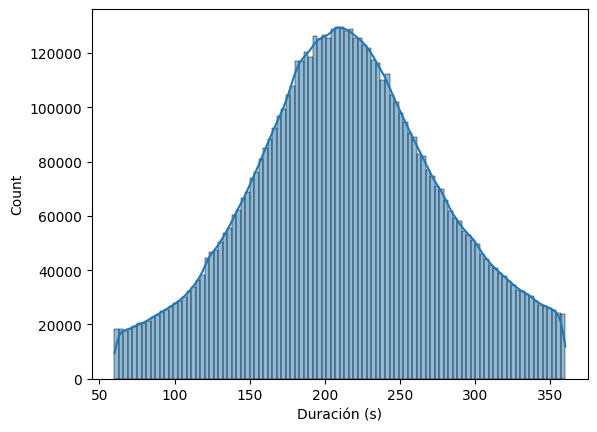

In [63]:
merged_data['Duración (s)'] = merged_data['track_duration_ms'] / 1000
# histograma de la duracion de las canciones
sns.histplot(
  data = merged_data,
  x = 'Duración (s)',
  bins = 100,
  kde = True,
)
merged_data.drop(columns=['Duración (s)'], inplace=True)

<Axes: xlabel='track_popularity', ylabel='Count'>

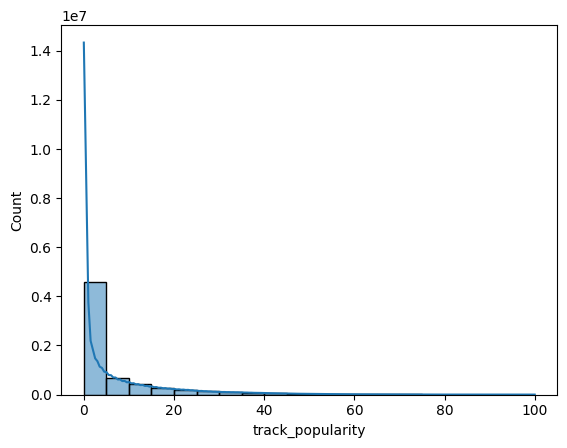

In [64]:
sns.histplot(
  data = merged_data,
  x = 'track_popularity',
  bins = 20,
  kde = True,
)

<Axes: xlabel='album_release_date', ylabel='Count'>

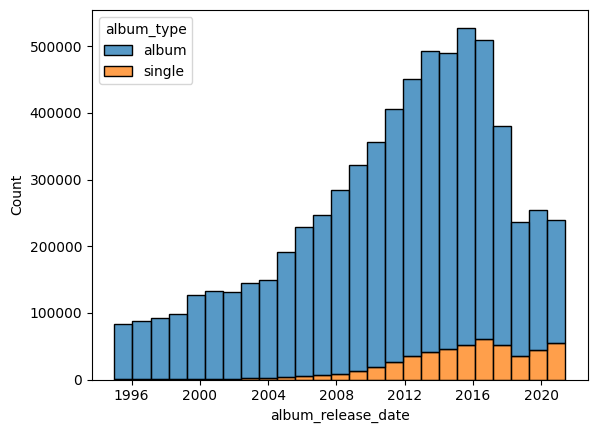

In [65]:
# plot release date
sns.histplot(
  data = merged_data,
  x = 'album_release_date',
  bins = 25,
  hue='album_type',
  multiple='stack',
)

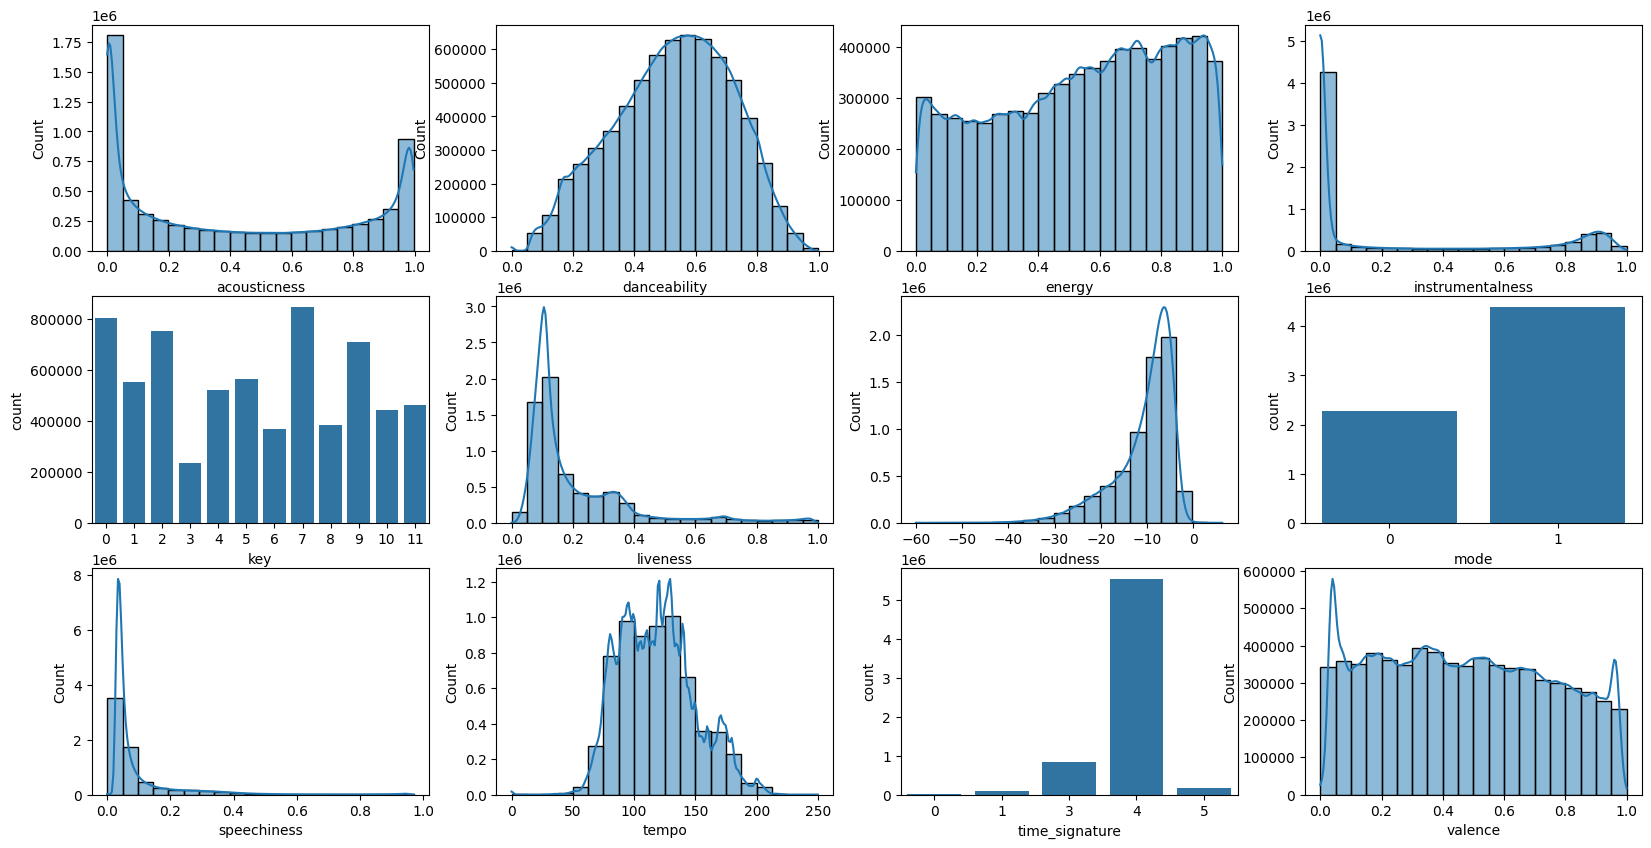

In [66]:
plot_columns = {
  'acousticness': 'continua',
  'danceability': 'continua',
  'energy': 'continua',
  'instrumentalness': 'continua',
  'key': 'discreta',
  'liveness': 'continua',
  'loudness': 'continua',
  'mode': 'discreta',
  'speechiness': 'continua',
  'tempo': 'continua',
  'time_signature': 'discreta',
  'valence': 'continua',
}
# plot multiples histogramas (12 columnas/features)
fig, axs = plt.subplots(3, 4, figsize=(20, 10))

for i, col in enumerate(plot_columns.keys()):
  if plot_columns[col] == 'continua':
    sns.histplot(
      data = merged_data,
      x = col,
      bins = 20,
      kde = True,
      ax = axs[i // 4, i % 4]
    )
  else:
    sns.countplot(
      data = merged_data,
      x = col,
      ax = axs[i // 4, i % 4]
    )

del plot_columns

# songs_normalize.csv

`songs_normalize.csv` es [un dataset de kaggle](https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019) de los mejores hits de spotify, considerando desde 2000 al 2019.

## carga y modificaciones iniciales

In [67]:
songs_normalize = pd.read_csv('data/songs_normalize.csv')
songs_normalize.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.7510,0.8340,1,-5.4440,0,0.0437,0.3000,0.0000,0.3550,0.8940,95.0530,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.4340,0.8970,0,-4.9180,1,0.0488,0.0103,0.0000,0.6120,0.6840,148.7260,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.5290,0.4960,7,-9.0070,1,0.0290,0.1730,0.0000,0.2510,0.2780,136.8590,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.5510,0.9130,0,-4.0630,0,0.0466,0.0263,0.0000,0.3470,0.5440,119.9920,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.6140,0.9280,8,-4.8060,0,0.0516,0.0408,0.0010,0.0845,0.8790,172.6560,pop


In [68]:
songs_normalize.shape

(2000, 18)

2000 filas y 18 columnas

In [69]:
songs_normalize.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   bool   
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


Podemos tratar un poco la columna `genre`, para que sea una lista de generos para cada cancion

In [70]:
songs_normalize['genre'] = songs_normalize['genre'].apply(
  # split and then strip each genre
  lambda x: [i.strip() for i in x.split(',')]
)
songs_normalize['genre'].head()

0             [pop]
1       [rock, pop]
2    [pop, country]
3     [rock, metal]
4             [pop]
Name: genre, dtype: object

## analisis y tratamiento de nulos

In [71]:
print(f"=== Has NaN? ===")
for col in songs_normalize.columns:
  if col == 'genre':
    print(col, songs_normalize[col].apply(lambda x: len(x) == 0).any())
  else:
    print(col, songs_normalize[col].hasnans)

=== Has NaN? ===
artist False
song False
duration_ms False
explicit False
year False
popularity False
danceability False
energy False
key False
loudness False
mode False
speechiness False
acousticness False
instrumentalness False
liveness False
valence False
tempo False
genre False


## analisis de columnas

In [72]:
songs_normalize.describe()

,duration_ms,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000
mean,228748.1245,2009.4940,59.8725,0.6674,0.7204,5.3780,-5.5124,0.5535,0.1036,0.1290,0.0152,0.1812,0.5517,120.1226
std,39136.5690,5.8600,21.3356,0.1404,0.1527,3.6151,1.9335,0.4973,0.0962,0.1733,0.0878,0.1407,0.2209,26.9671
min,113000.0000,1998.0000,0.0000,0.1290,0.0549,0.0000,-20.5140,0.0000,0.0232,0.0000,0.0000,0.0215,0.0381,60.0190
25%,203580.0000,2004.0000,56.0000,0.5810,0.6220,2.0000,-6.4902,0.0000,0.0396,0.0140,0.0000,0.0881,0.3868,98.9857
50%,223279.5000,2010.0000,65.5000,0.6760,0.7360,6.0000,-5.2850,1.0000,0.0599,0.0557,0.0000,0.1240,0.5575,120.0215
75%,248133.0000,2015.0000,73.0000,0.7640,0.8390,8.0000,-4.1677,1.0000,0.1290,0.1762,0.0001,0.2410,0.7300,134.2655
max,484146.0000,2020.0000,89.0000,0.9750,0.9990,11.0000,-0.2760,1.0000,0.5760,0.9760,0.9850,0.8530,0.9730,210.8510


In [73]:
songs_normalize.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   bool   
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


In [74]:
songs_normalize['explicit'].value_counts()

explicit
False    1449
True      551
Name: count, dtype: int64

In [75]:
songs_normalize['year'].value_counts().sort_index()

year
1998      1
1999     38
2000     74
2001    108
2002     90
2003     97
2004     96
2005    104
2006     95
2007     94
2008     97
2009     84
2010    107
2011     99
2012    115
2013     89
2014    104
2015     99
2016     99
2017    111
2018    107
2019     89
2020      3
Name: count, dtype: int64

Tenemos un buen balance de canciones que salieron en los 2000 - 2019, pero fuera de ese rango existe una cantidad significativa de canciones.

In [76]:
# obtain the genres
songs_normalize_genres = dict()
for genre_list in songs_normalize['genre']:
  for genre in genre_list:
    if genre not in songs_normalize_genres:
      songs_normalize_genres[genre] = 0
    songs_normalize_genres[genre] += 1

songs_normalize_genres = pd.DataFrame.from_dict(songs_normalize_genres, orient='index', columns=['count'])
songs_normalize_genres.sort_values(by='count', ascending=False, inplace=True)
songs_normalize_genres.head()

,count
pop,1633
hip hop,778
R&B,452
Dance/Electronic,390
rock,234


In [77]:
songs_normalize_genres.shape

(15, 1)

Solamente hay 15 generos

# charts.csv

`charts.csv` es [un dataset de kaggle](https://www.kaggle.com/datasets/dhruvildave/spotify-charts) que compila las colecciones "Top 200" y "50 virales" desde 2017 al 2021. Estas colecciones se publican globalmente cada 2-3 dias, dando informacion valiosa historica y alto valor de analisis.

## carga y modificaciones iniciales

In [78]:
charts = pd.read_csv('data/charts.csv')
charts.head()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6lroV2Kg,Argentina,top200,SAME_POSITION,253019.0000
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul3ywMe46,Argentina,top200,MOVE_UP,223988.0000
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAOSC1qTfo,Argentina,top200,MOVE_DOWN,210943.0000
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtcMZ4S4bO,Argentina,top200,SAME_POSITION,173865.0000
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37DOZPJ2hf,Argentina,top200,MOVE_UP,153956.0000


In [79]:
charts.shape

(26173514, 9)

26.173.541 filas y 9 columnas

In [80]:
charts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26173514 entries, 0 to 26173513
Data columns (total 9 columns):
 #   Column   Dtype  
---  ------   -----  
 0   title    object 
 1   rank     int64  
 2   date     object 
 3   artist   object 
 4   url      object 
 5   region   object 
 6   chart    object 
 7   trend    object 
 8   streams  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 1.8+ GB


Inicialmente notemos que hay columnas que podemos expresar como de tipo fechas y otras declarar como columnas categoricas.

In [81]:
charts['date'] = pd.to_datetime(charts['date'])
charts['region'] = charts['region'].astype('category')
charts['chart'] = charts['chart'].astype('category')
charts['trend'] = charts['trend'].astype('category')

In [82]:
charts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26173514 entries, 0 to 26173513
Data columns (total 9 columns):
 #   Column   Dtype         
---  ------   -----         
 0   title    object        
 1   rank     int64         
 2   date     datetime64[ns]
 3   artist   object        
 4   url      object        
 5   region   category      
 6   chart    category      
 7   trend    category      
 8   streams  float64       
dtypes: category(3), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.2+ GB


## analisis y tratamiento de nulos

In [83]:
print(f"=== Has NaN? ===")
for col in charts.columns:
  print(col, charts[col].hasnans)

=== Has NaN? ===
title True
rank False
date False
artist True
url False
region False
chart False
trend False
streams True


In [84]:
charts['title'].hasnans

True

`title` tiene valores faltantes, veamos cuantos son

In [85]:
charts[charts['title'].isna()].shape

(11, 9)

solamente 11 filas con titulo de cancion faltante veamos cuales son

In [86]:
charts[charts['title'].isna()]

,title,rank,date,artist,url,region,chart,trend,streams
7305002,NaN,120,2019-06-24,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,top200,NEW_ENTRY,11942.0000
7401555,NaN,167,2019-06-25,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,top200,MOVE_DOWN,10310.0000
7479161,NaN,128,2019-06-26,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,top200,MOVE_UP,11620.0000
7563494,NaN,164,2019-06-27,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,top200,MOVE_DOWN,10229.0000
7670140,NaN,174,2019-06-28,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,top200,MOVE_DOWN,9348.0000
7772268,NaN,188,2019-06-29,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,top200,MOVE_DOWN,9808.0000
7879888,NaN,169,2019-06-30,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,top200,MOVE_UP,10900.0000
14391788,NaN,38,2019-07-15,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,viral50,NEW_ENTRY,NaN
14481594,NaN,48,2019-07-16,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,viral50,MOVE_DOWN,NaN
14768101,NaN,46,2019-07-17,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,viral50,MOVE_UP,NaN


Accediendo a la url y al artista por internet, podemos encontrar que existe una cancion llamada "NA", probablemente ocurrio algun error al ser cargadas. Podemos arreglarlo facilmente.

In [87]:
# fix the title "NA"
charts.loc[charts['title'].isna(), 'title'] = 'NA'

In [88]:
charts[charts['title'].isna()].shape

(0, 9)

In [89]:
charts[charts['title']=='NA']

,title,rank,date,artist,url,region,chart,trend,streams
7305002,NA,120,2019-06-24,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,top200,NEW_ENTRY,11942.0000
7401555,NA,167,2019-06-25,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,top200,MOVE_DOWN,10310.0000
7479161,NA,128,2019-06-26,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,top200,MOVE_UP,11620.0000
7563494,NA,164,2019-06-27,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,top200,MOVE_DOWN,10229.0000
7670140,NA,174,2019-06-28,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,top200,MOVE_DOWN,9348.0000
7772268,NA,188,2019-06-29,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,top200,MOVE_DOWN,9808.0000
7879888,NA,169,2019-06-30,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,top200,MOVE_UP,10900.0000
14391788,NA,38,2019-07-15,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,viral50,NEW_ENTRY,NaN
14481594,NA,48,2019-07-16,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,viral50,MOVE_DOWN,NaN
14768101,NA,46,2019-07-17,Nissy,https://open.spotify.com/track/4cP6KmNvTFkLHZo6fVJq0c,Japan,viral50,MOVE_UP,NaN


In [90]:
charts['artist'].hasnans

True

`artist` tiene valores faltantes, veamos cuantos son

In [91]:
charts[charts['artist'].isna()].shape

(18, 9)

solamente 18 filas tienen artista faltante, veamos cuales son

In [92]:
charts[charts['artist'].isna()]

,title,rank,date,artist,url,region,chart,trend,streams
20596664,NO GOOD,10,2020-07-13,NaN,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,NEW_ENTRY,NaN
20616457,NO GOOD,10,2020-07-14,NaN,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,SAME_POSITION,NaN
20640094,NO GOOD,10,2020-07-15,NaN,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,SAME_POSITION,NaN
20661724,NO GOOD,10,2020-07-16,NaN,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,SAME_POSITION,NaN
20677645,NO GOOD,10,2020-07-17,NaN,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,SAME_POSITION,NaN
20705363,NO GOOD,10,2020-07-18,NaN,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,SAME_POSITION,NaN
20726697,NO GOOD,10,2020-07-19,NaN,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,SAME_POSITION,NaN
20748638,NO GOOD,13,2020-07-20,NaN,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,MOVE_DOWN,NaN
20788975,NO GOOD,14,2020-07-21,NaN,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,MOVE_DOWN,NaN
20833982,NO GOOD,19,2020-07-22,NaN,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,MOVE_DOWN,NaN


Buscando en internet la cancion, podemos identificar que el artista tiene nombre "N/A", probablemente ocurrio algun error al ser cargadas. Solucionemoslo.

In [93]:
# fix the artist name "N/A"
charts.loc[charts['artist'].isna(), 'artist'] = 'N/A'

In [94]:
charts[charts['artist'].isna()].shape

(0, 9)

In [95]:
charts[charts['artist']=='N/A']

,title,rank,date,artist,url,region,chart,trend,streams
20596664,NO GOOD,10,2020-07-13,N/A,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,NEW_ENTRY,NaN
20616457,NO GOOD,10,2020-07-14,N/A,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,SAME_POSITION,NaN
20640094,NO GOOD,10,2020-07-15,N/A,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,SAME_POSITION,NaN
20661724,NO GOOD,10,2020-07-16,N/A,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,SAME_POSITION,NaN
20677645,NO GOOD,10,2020-07-17,N/A,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,SAME_POSITION,NaN
20705363,NO GOOD,10,2020-07-18,N/A,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,SAME_POSITION,NaN
20726697,NO GOOD,10,2020-07-19,N/A,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,SAME_POSITION,NaN
20748638,NO GOOD,13,2020-07-20,N/A,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,MOVE_DOWN,NaN
20788975,NO GOOD,14,2020-07-21,N/A,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,MOVE_DOWN,NaN
20833982,NO GOOD,19,2020-07-22,N/A,https://open.spotify.com/track/4Qnz8tARYhUtDNePNsLx2C,Japan,viral50,MOVE_DOWN,NaN


In [96]:
charts['streams'].hasnans

True

`streams` tiene valores faltantes, veamos cuantos son

In [97]:
charts[charts['streams'].isna()].shape

(5851610, 9)

5.851.610 filas tienen `streams` faltantes, veamos a que colecciones pertenecen

In [98]:
charts[charts['streams'].isna()]['chart'].value_counts()

chart
viral50    5851610
top200           0
Name: count, dtype: int64

Todas las 5.851.610 filas son de la coleccion "50 Virales", comprobemos si es que esa coleccion no tiene `streams` en todos sus casos.

In [99]:
charts[charts['chart']=='viral50']['streams'].isna().value_counts()

streams
True    5851610
Name: count, dtype: int64

En efecto, las 5.851.610 filas que no poseen `streams` es debido a que las canciones de la coleccion "50 Virales" no poseen tal informacion.

## analisis de columnas

In [100]:
charts.describe()

,rank,date,streams
count,26173514.0000,26173514,20321904.0000
mean,80.9231,2019-08-20 15:35:30.458598912,55261.3144
min,1.0000,2017-01-01 00:00:00,1001.0000
25%,29.0000,2018-06-16 00:00:00,3546.0000
50%,67.0000,2019-09-18 00:00:00,9565.0000
75%,131.0000,2020-11-11 00:00:00,35409.0000
max,200.0000,2021-12-31 00:00:00,19749704.0000
std,59.1860,NaN,209587.2447


In [101]:
charts['region'].value_counts().sort_values(ascending=False)

region
Argentina        455308
United States    455057
Austria          454593
Brazil           454439
Australia        453103
                  ...  
Ukraine          127544
Russia           126837
Luxembourg        98053
Andorra           79592
South Korea       76276
Name: count, Length: 70, dtype: int64

In [102]:
charts['chart'].value_counts()

chart
top200     20321904
viral50     5851610
Name: count, dtype: int64

Los datos se encuentran en proporcion 200:50 = 4:1

In [103]:
charts['trend'].value_counts()

trend
MOVE_DOWN        11220434
MOVE_UP           9801048
SAME_POSITION     3298392
NEW_ENTRY         1853640
Name: count, dtype: int64

In [104]:
charts['title'].unique().shape, charts['artist'].unique().shape

((164807,), (96157,))

Tenemos 164.807 canciones y 96.157 artistas unicos

In [105]:
charts['date'].unique().shape

(1826,)

tenemos 1.826 fechas distintas

In [106]:
charts['date'].dt.year.value_counts().sort_index()

date
2017    4401145
2018    4863016
2019    5412669
2020    5793148
2021    5703536
Name: count, dtype: int64

En general, tenemos datos balanceados en los años

# data.csv

`data.csv` es un [dataset de kaggle](https://www.kaggle.com/datasets/ivannatarov/spotify-daily-top-200-songs-with-genres-20172021) que contiene la coleccion "Top 200" obtenida diariamente desde 2017 hasta 2021. \
El usuario que subio este dataset declara que es util para principiantes, dado que contiene cosas que se suelen tratar en la exploracion de datos.

## carga y modificaciones iniciales

In [107]:
data = pd.read_csv('data/data.csv', delimiter='#')
data.head()

,Position,Track Name,Artist,Streams,Date,Genre
0,1,Starboy,The Weeknd,3135625,2017-01-01,"['canadian pop', 'canadian contemporary r&b', 'pop']"
1,2,Closer,The Chainsmokers,3015525,2017-01-01,"['pop', 'pop dance', 'tropical house', 'edm', 'electropop', 'dance pop']"
2,3,Let Me Love You,DJ Snake,2545384,2017-01-01,"['pop', 'electronic trap', 'dance pop', 'edm', 'pop dance', 'pop rap']"
3,4,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,2356604,2017-01-01,"['pop', 'uk dance', 'dance pop', 'uk funky', 'tropical house', 'pop dance', 'post-teen pop', 'edm']"
4,5,One Dance,Drake,2259887,2017-01-01,"['toronto rap', 'canadian pop', 'canadian hip hop', 'rap', 'pop rap', 'hip hop']"


In [108]:
data.shape

(321200, 6)

In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321200 entries, 0 to 321199
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Position    321200 non-null  int64 
 1   Track Name  321182 non-null  object
 2   Artist      321182 non-null  object
 3   Streams     321200 non-null  int64 
 4   Date        321200 non-null  object
 5   Genre       321182 non-null  object
dtypes: int64(2), object(4)
memory usage: 14.7+ MB


In [110]:
data['Date'] = pd.to_datetime(data['Date'])

los generos estan como string para pandas, pero podemos notar que tiene nulos, tenemos que tratarlos primero

## analisis y tratamiento de nulos

In [111]:
print(f"=== Has NaN? ===")
for col in data.columns:
  print(col, data[col].hasnans)

=== Has NaN? ===
Position False
Track Name True
Artist True
Streams False
Date False
Genre True


In [112]:
data[data['Track Name'].isna()].shape

(18, 6)

In [113]:
data[data['Artist'].isna()].shape

(18, 6)

In [114]:
data[data['Genre'].isna()].shape

(18, 6)

es bastante sospechoso que sean 18 en todas estas columnas

In [115]:
data[data['Track Name'].isna() | data['Artist'].isna() | data['Genre'].isna()]

,Position,Track Name,Artist,Streams,Date,Genre
39204,5,NaN,NaN,3568811,2017-07-20,NaN
39212,13,NaN,NaN,2571960,2017-07-20,NaN
39229,30,NaN,NaN,1798208,2017-07-20,NaN
39238,39,NaN,NaN,1520291,2017-07-20,NaN
39404,5,NaN,NaN,3653533,2017-07-21,NaN
39415,16,NaN,NaN,2522453,2017-07-21,NaN
39434,35,NaN,NaN,1798890,2017-07-21,NaN
39447,48,NaN,NaN,1526955,2017-07-21,NaN
39700,101,NaN,NaN,747893,2017-07-22,NaN
39888,89,NaN,NaN,690247,2017-07-23,NaN


Lamentablemente no hay muchos datos que podamos sacar de esto sin las columnas que faltan

In [116]:
remove_data = data[data['Track Name'].isna() | data['Artist'].isna() | data['Genre'].isna()]
data.drop(remove_data.index, inplace=True)
del remove_data

print(f"=== Has NaN? ===")
for col in data.columns:
  print(col, data[col].hasnans)

=== Has NaN? ===
Position False
Track Name False
Artist False
Streams False
Date False
Genre False


Ahora que ya no hay nulos, trataremos la columna `Genre`

In [117]:
import re
def process_genres_str(x: str):
  # delete ' and " characters
  # delete the first and last character (they are [ and ])
  # split by , and then strip each genre
  return [i.strip() for i in re.sub(r'\'|\"', '', x)[1:-1].split(',')]

data['Genre'] = data['Genre'].apply(process_genres_str)
data['Genre'].head()

0                                         [canadian pop, canadian contemporary r&b, pop]
1                           [pop, pop dance, tropical house, edm, electropop, dance pop]
2                             [pop, electronic trap, dance pop, edm, pop dance, pop rap]
3    [pop, uk dance, dance pop, uk funky, tropical house, pop dance, post-teen pop, edm]
4                   [toronto rap, canadian pop, canadian hip hop, rap, pop rap, hip hop]
Name: Genre, dtype: object

## analisis de columnas

In [118]:
data.describe()

,Position,Streams,Date
count,321182.0000,321182.0000,321182
mean,100.5028,1188463.9883,2019-03-19 19:07:35.405346816
min,1.0000,325951.0000,2017-01-01 00:00:00
25%,51.0000,700483.2500,2018-02-10 00:00:00
50%,101.0000,895351.0000,2019-03-19 00:00:00
75%,151.0000,1364059.0000,2020-04-23 00:00:00
max,200.0000,17223237.0000,2021-07-17 00:00:00
std,57.7336,839659.5540,NaN


In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321182 entries, 0 to 321199
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Position    321182 non-null  int64         
 1   Track Name  321182 non-null  object        
 2   Artist      321182 non-null  object        
 3   Streams     321182 non-null  int64         
 4   Date        321182 non-null  datetime64[ns]
 5   Genre       321182 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 17.2+ MB


In [120]:
data['Track Name'].unique().shape, data['Artist'].unique().shape

((5496,), (1127,))

5.496 canciones y 1.127 artistas unicos

In [121]:
data['Date'].dt.year.value_counts().sort_index()

Date
2017    72182
2018    73000
2019    73000
2020    72000
2021    31000
Name: count, dtype: int64

Tenemos un muy buen balance entre las canciones de 2017 - 2020, en 2021 faltan, pero es esperable dada la fecha maxima encontrada

In [122]:
# obtain the genres
data_genres = dict()
for genre_list in data['Genre']:
  for genre in genre_list:
    if genre not in data_genres:
      data_genres[genre] = 0
    data_genres[genre] += 1

data_genres = pd.DataFrame.from_dict(data_genres, orient='index', columns=['count'])
data_genres.sort_values(by='count', ascending=False, inplace=True)
data_genres.head()

,count
pop,146708
dance pop,89558
rap,66629
post-teen pop,64118
pop rap,48831


In [123]:
data_genres.shape

(636, 1)

tenemos 636 generos